In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import re

In [11]:
datapath = "Datasets/Events encoded DBS data (2).xlsx"
df = pd.read_excel(datapath)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.drop(columns=['Vol.'])
df.head()


c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Price,Open,High,Low,Change %,vol_clean,Event,Event_Description,Is_Event_Positive,is_event_day,is_event_positive_flag,is_covid_period,regime
Date,,,,,,,,,,,,,
2014-01-02,15.06,15.15,15.17,15.02,0.00,2030000.0,NaN,NaN,NaN,0,0,0,0
2014-01-03,14.96,15.04,15.06,14.86,-0.01,2730000.0,NaN,NaN,NaN,0,0,0,0
2014-01-04,14.96,15.04,15.06,14.86,-0.01,2730000.0,NaN,NaN,NaN,0,0,0,0
2014-01-05,14.99,14.96,15.00,14.90,0.00,1370000.0,NaN,NaN,NaN,0,0,0,0
2014-01-06,14.99,14.96,15.00,14.90,0.00,1370000.0,NaN,NaN,NaN,0,0,0,0


In [28]:
scaler = MinMaxScaler()
# Drop 'Vol.' column if it exists
if 'Vol.' in df.columns:
    df = df.drop(columns=['Vol.'])
# Map common boolean-like strings to numeric
df = df.replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'True': 1, 'False': 0, 'true': 1, 'false': 0})
# For any remaining object/string columns, try to remove common non-numeric chars and coerce to numeric
for col in df.columns:
    if df[col].dtype == object or pd.api.types.is_string_dtype(df[col]):
        # remove commas and currency symbols, percent handled separately if needed
        try:
            cleaned = df[col].astype(str).str.replace(',', '').str.replace('$', '').str.replace('£', '').str.replace('€', '')
            # coerce to numeric where possible; non-convertible values become NaN
            df[col] = pd.to_numeric(cleaned, errors='ignore')
        except Exception:
            pass
# Select numeric columns only for scaling
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] == 0:
    raise ValueError('No numeric columns available for scaling after coercion.')
# Choose a target column: prefer common price/close names if present, else use first numeric column
preferred_targets = ['Low','High','Open','Price']
target_col = None
for t in preferred_targets:
    if t in numeric_df.columns:
        target_col = t
        break
if target_col is None:
    target_col = numeric_df.columns[0]
# Reorder so target is first column (create_sequences expects target at index 0)
cols = [target_col] + [c for c in numeric_df.columns if c != target_col]
numeric_df = numeric_df[cols]
# Fit scaler on numeric values and keep numeric_df for later inverse transforms
scaled_data = scaler.fit_transform(numeric_df.values)
print('target column used for forecasting:', target_col)
print('scaled_data shape:', scaled_data.shape)
numeric_df.head()

target column used for forecasting: Low
scaled_data shape: (4043, 10)


,Low,Price,Open,High,Change %,vol_clean,is_event_day,is_event_positive_flag,is_covid_period,regime
Date,,,,,,,,,,
2014-01-02,15.02,15.06,15.15,15.17,0.00,2030000.0,0,0,0,0
2014-01-03,14.86,14.96,15.04,15.06,-0.01,2730000.0,0,0,0,0
2014-01-04,14.86,14.96,15.04,15.06,-0.01,2730000.0,0,0,0,0
2014-01-05,14.90,14.99,14.96,15.00,0.00,1370000.0,0,0,0,0
2014-01-06,14.90,14.99,14.96,15.00,0.00,1370000.0,0,0,0,0


In [29]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window, 0])
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_data, 20)

In [30]:
split = int(0.85 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [31]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape=(
    X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,501 (173.83 KB)

 Trainable params: 44,501 (173.83 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16)

Epoch 1/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0031 - mae: 0.0366
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.8613e-04 - mae: 0.0221
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5213e-04 - mae: 0.0189
Epoch 4/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2189e-04 - mae: 0.0170
Epoch 5/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9159e-04 - mae: 0.0163
Epoch 6/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2892e-04 - mae: 0.0151
Epoch 7/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2009e-04 - mae: 0.0149
Epoch 8/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8489e-04 - mae: 0.0143
Epoch 9/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4545e-04 - mae: 0.0134
Epoch 10/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2217e-04 - mae: 0.0130
Epoch 11/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0237e-04 - mae: 0.0125
Epoch 12/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1416

In [19]:
pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [23]:
y_test_inv = scaler.inverse_transform(
    np.c_[y_test, np.zeros((len(y_test), numeric_df.shape[1] - 1))]
)[:, 0]

pred_inv = scaler.inverse_transform(
    np.c_[pred, np.zeros((len(pred), numeric_df.shape[1] - 1))]
)[:, 0]

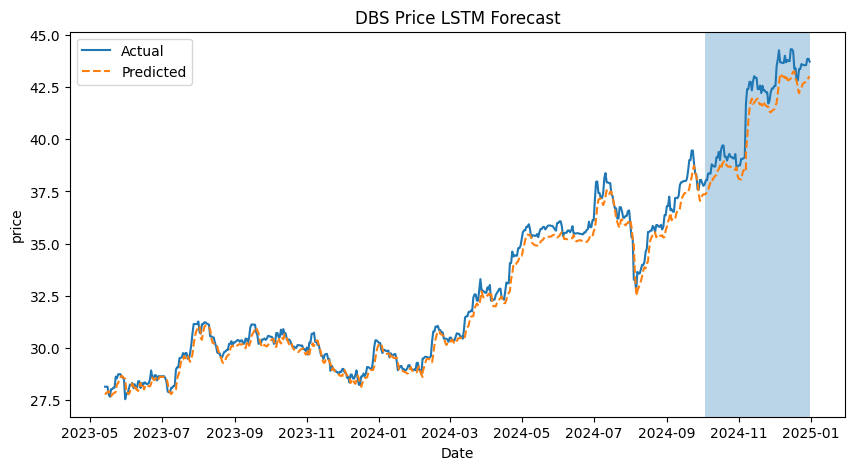

In [25]:
time = df.index[-len(y_test):]

plt.figure(figsize=(10, 5))
plt.plot(time, y_test_inv, label="Actual")
plt.plot(time, pred_inv, linestyle="--", label="Predicted")

highlight = int(len(time) * 0.85)
plt.axvspan(time[highlight], time[-1], alpha=0.3)

plt.title("DBS Price LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("price")
plt.legend()
plt.show()

In [27]:
mse = mean_squared_error(y_test_inv, pred_inv)
mae = mean_absolute_error(y_test_inv, pred_inv)
r2 = r2_score(y_test_inv, pred_inv)

print("MSE: ",mse)
print("MAE: ",mae)
print("R2: ",r2)

MSE:  0.3134834321926325
MAE:  0.4231576625420536
R2:  0.9849188286479156
